In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import sqrt

import sys
sys.path.append('../../../')

from fedlab.utils.dataset import SVHNPartitioner
from fedlab.utils.functional import partition_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN
from torchvision.utils import make_grid
import torchvision.transforms as transforms

In [2]:
%matplotlib inline

def dict_value2key(d, value):
    return list(d.keys())[list(d.values()).index(value)]

# Load Data

In [3]:
root = "../../../../data/SVHN"
transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(
                                          mean=(0.5, 0.5, 0.5),
                                          std=(0.5, 0.5, 0.5))])
trainset = SVHN(root=root, split='train', download=True, transform=transforms.ToTensor())

100%|██████████| 182M/182M [01:26<00:00, 2.11MB/s] 


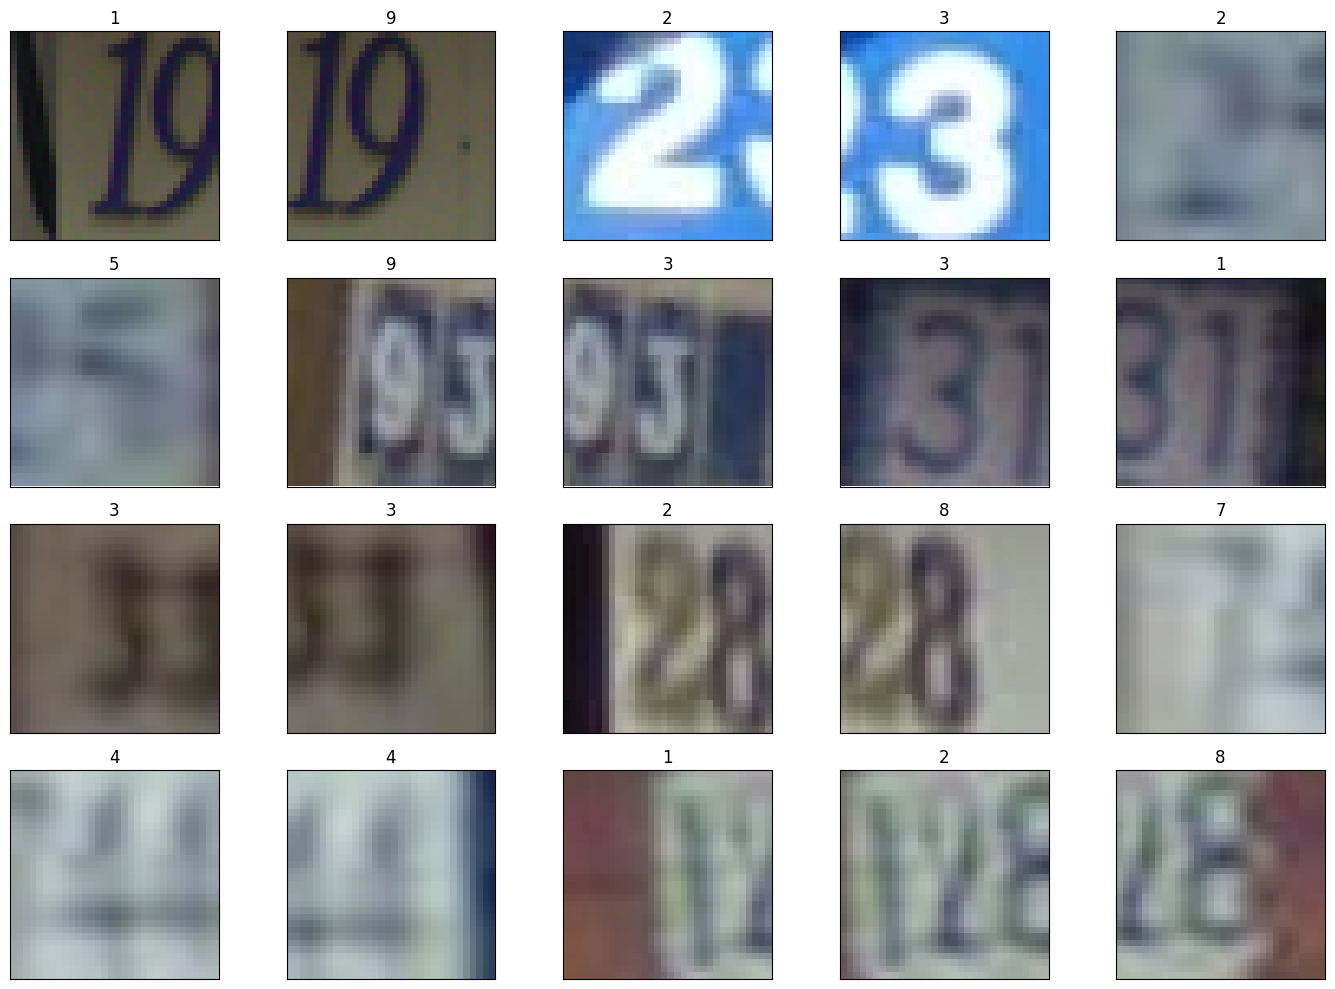

In [5]:
fig = plt.figure(figsize=(15, 10))

for idx in range(20):
    ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])
    ax.imshow(trainset[idx][0].permute(1,2,0))
    cls_name = trainset[idx][1]
    ax.set_title(f"{cls_name}")
    ax.patch.set_facecolor('white')
    fig.tight_layout()
    
fig.savefig("./imgs/svhn_vis.png", dpi=400, bbox_inches = 'tight')

# Data Partition

In [6]:
num_classes = 10
num_clients = 10
seed = 2021

col_names = [f"class{i}" for i in range(num_classes)]

hist_color = '#4169E1'
plt.rcParams['figure.facecolor'] = 'white'

In [7]:
# this class is from NIID-bench official code: 
# https://github.com/Xtra-Computing/NIID-Bench/blob/main/utils.py
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., net_id=None, total=0):
        self.std = std
        self.mean = mean
        self.net_id = net_id
        self.num = int(sqrt(total))
        if self.num * self.num < total:
            self.num = self.num + 1

    def __call__(self, tensor):
        if self.net_id is None:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            tmp = torch.randn(tensor.size())
            filt = torch.zeros(tensor.size())
            size = int(28 / self.num)
            row = int(self.net_id / size)
            col = self.net_id % size
            for i in range(size):
                for j in range(size):
                    filt[:, row * size + i, col * size + j] = 1
            tmp = tmp * filt
            return tensor + tmp * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


Here we only show "feature distribution skew"-"noise based" visualization result, since other partitions are similar with [FMNIST](../fmnist/fmnist_tutorial.ipynb).

22:32:17 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.029688276..1.025702].
22:32:19 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.055778045..1.0706278].
22:32:20 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018427148..1.0913672].
22:32:22 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.013088644..1.1105176].
22:32:23 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04350333..1.1683145].
22:32:25 - matplotlib.image - WARNING - Clipping input data to the vali

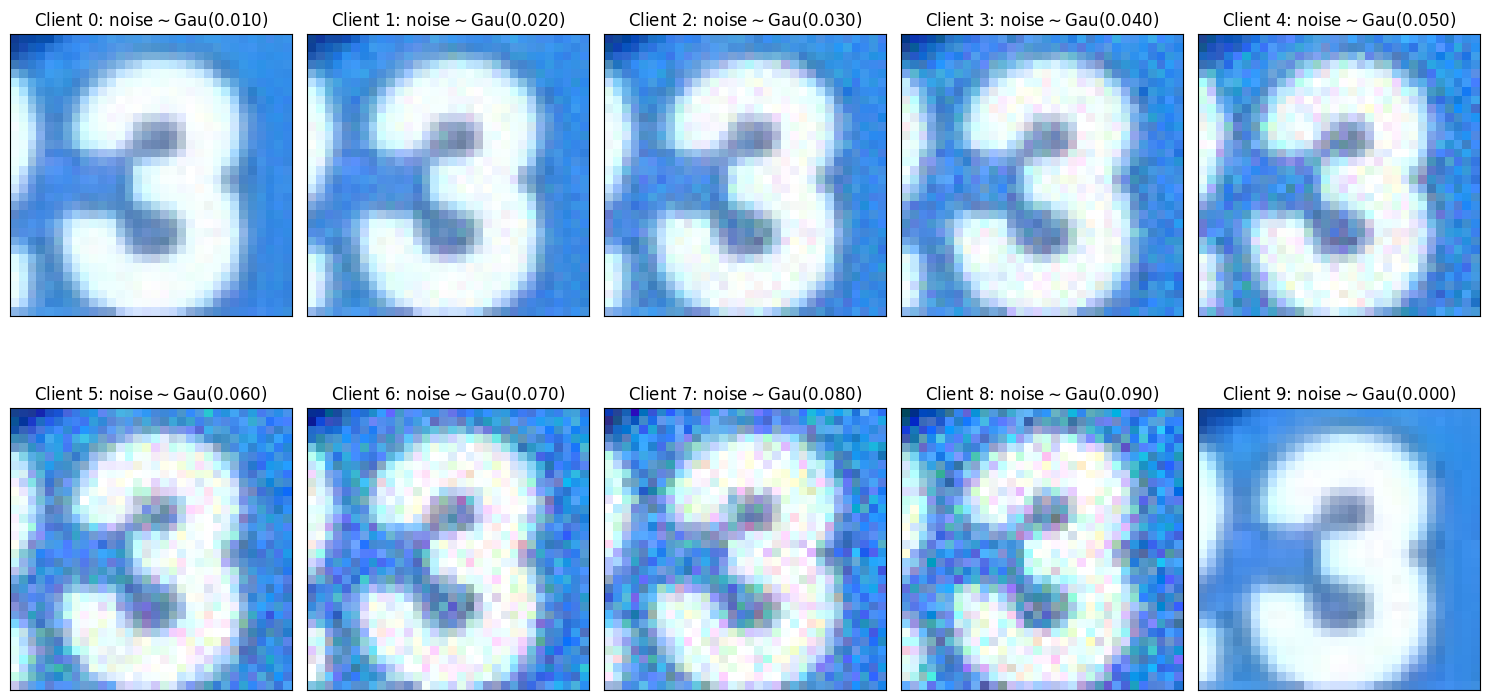

In [9]:
noise = 0.1
num_clients = 10
img_idx = 3

fig = plt.figure(figsize=(15, 10))

for cid in range(num_clients):
    if cid == num_clients - 1:
        noise_level = 0
    else:
        noise_level = noise / num_clients * (cid + 1)  # a little different from original NIID-bench
    transform = transforms.Compose([transforms.ToTensor(),
                                    AddGaussianNoise(0., noise_level)])
    trainset_feature_skew = SVHN(root=root, split='train', download=False, 
                                         transform=transform)
    ax = fig.add_subplot(2, int(num_clients/2), cid + 1, xticks=[], yticks=[])
    ax.imshow(trainset_feature_skew[img_idx][0].permute(1,2,0))
    ax.set_title(f"Client {cid}: noise$\sim$Gau({noise_level:.3f})")
    ax.patch.set_facecolor('white')
    fig.tight_layout()

print(f"Label: {trainset_feature_skew[img_idx][1]}")
fig.savefig("./imgs/svhn_feature_skew_vis.png", dpi=400, bbox_inches = 'tight')